In [53]:
# %%capture
# %run setup_PS_data_multi.ipynb
# print('------------------------------------')
# print(f'{len(sessions)} sessions are loaded')
import os
import sys
sys.path.append('..')
import pickle
import Session
path_to_vape = os.path.expanduser('~/Documents/code/Vape')
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))

popoff_path = os.path.expanduser('~/Documents/code/pop-off')
sessions_path = os.path.join(popoff_path, 'sessions.pkl')

with open(sessions_path, 'rb') as f:
    sessions = pickle.load(f)
    

UnpicklingError: NEWOBJ class argument isn't a type object

In [2]:
#remove J065 run 14 because there is an alignment error
for idx, session in sessions.items():
    rep = repr(session)
    if 'J065' in rep and 'run 14' in rep:
        del_idx = idx
        del sessions[del_idx] 
        break
sessions

{0: instance Mouse J048, run 27 of Session class,
 1: instance Mouse J048, run 28 of Session class,
 2: instance Mouse J048, run 29 of Session class,
 3: instance Mouse J048, run 30 of Session class,
 4: instance Mouse J048, run 32 of Session class,
 5: instance Mouse RL048, run 23 of Session class,
 6: instance Mouse RL048, run 24 of Session class,
 7: instance Mouse RL048, run 25 of Session class,
 8: instance Mouse RL048, run 28 of Session class,
 9: instance Mouse RL048, run 29 of Session class,
 10: instance Mouse J063, run 8 of Session class,
 11: instance Mouse J063, run 9 of Session class,
 12: instance Mouse J064, run 10 of Session class,
 13: instance Mouse J064, run 11 of Session class,
 14: instance Mouse J064, run 14 of Session class,
 15: instance Mouse J065, run 10 of Session class,
 16: instance Mouse J065, run 11 of Session class,
 18: instance Mouse RL070, run 28 of Session class,
 19: instance Mouse RL070, run 29 of Session class}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [5]:
session.__dict__.keys()

dict_keys(['mouse', 'run_number', 'pkl_path', 'name', 'run', 'pre_seconds', 'post_seconds', 'pre_gap_seconds', 'post_gap_seconds', 'verbose', 'flu', 'tstart_galvo', 'trial_start', 'galvo_ms', 'subsets', 'trial_subsets', 'n_stim_arr', 'outcome', 'outcome_arr', 'n_cells', 'av_ypix', 'av_xpix', 'plane_number', 's2_bool', 's1_bool', 'frequency', 'pre_frames', 'post_frames', 'art_gap_start', 'final_pre_gap_tp', 'art_gap_stop', 'filter_ps_array', 'filter_ps_time', 'behaviour_trials', 'decision', 'photostim', 'photostim_occ', 'autorewarded', 'n_unique_stims', 'n_neurons', 'n_times', 'n_trials', 'n_unique_dec', 'occ_table', 'n_com_trials', 'nonnan_trials'])

In [6]:
## Integrate different imaging frequencies:

def get_tp_dict(sessions):
    freqs = np.unique([ss.frequency for _, ss in sessions.items()])
    tp_dict = {}
    for ff in freqs:
        for _, ss in sessions.items():   # assume pre_seconds & post_seconds equal for all sessions
            if ss.frequency == ff:
                tp_dict[ff] = ss.filter_ps_time
    if len(freqs) == 2:  # for hard-coded bit next up
        tp_dict['mutual'] = np.intersect1d(ar1=tp_dict[freqs[0]], ar2=tp_dict[freqs[1]])
    elif len(freqs) == 1:
        tp_dict['mutual'] = tp_dict[freqs[0]]
    
    return tp_dict

In [7]:
def get_frames_use(session, times_use):

    frames_use = []
    for tt in times_use:
        # this will throw an error if tt not in filter_ps_time
        frames = session.filter_ps_array[np.where(session.filter_ps_time == tt)[0][0]]
        frames_use.append(frames)
        
    assert len(times_use) == len(frames_use) 
    return np.array(frames_use)

In [8]:
tp_dict = get_tp_dict(sessions)
for idx, session in sessions.items():
    session.frames_use = get_frames_use(session, tp_dict['mutual'])

In [11]:
def mean_flu(flu, cells_use='all', trials_use='all', frames_use='all'):
    
    if cells_use == 'all':
        cells_use = np.arange(flu.shape[0])
    if trials_use == 'all':
        trials_use = np.arange(flu.shape[1])
    if frames_use == 'all':
        frames_use = np.arange(flu.shape[2])
       
    # Do each index seperately to prevent IndexError due to shape mismatch
    flu = flu[cells_use, :, :]
    flu = flu[:, trials_use, :]
    flu = flu[:, :, frames_use]
    
    return np.mean(flu, (0,1))

In [46]:
def mean_across_sessions(sessions, trial_type='all', trial_outcome='all'):
    
    count = 0

    for idx, session in sessions.items():
        
        assert len(session.photostim) == len(session.decision)
        
        if session.mouse!='RL048':
            continue
        
        if trial_type == 'nogo':
            type_use = session.photostim == 0
        elif trial_type == 'test':
            type_use = session.photostim == 1
        elif trial_type == 'easy':
            type_use = session.photostim == 2
        elif trial_type == 'all':
            type_use = np.repeat(True, len(session.photostim))
        
        if trial_outcome == 'hit':
            outcome_use = session.decision == 1
        elif trial_outcome == 'miss':
            outcome_use = session.decision == 0
        elif trial_outcome == 'all':
            outcome_use = np.repeat(True, len(session.decision)) 
        
        trials_use = type_use & outcome_use

        mean_abs_df = np.mean(np.abs(session.run.flu), 1)
        abs_threshold=5
        
        filtered_neurons = np.where(mean_abs_df < abs_threshold)[0]
        flu = session.behaviour_trials[filtered_neurons, :, :]
        frames_use = session.frames_use

        if count == 0:
            mean_session = mean_flu(flu, trials_use=trials_use, frames_use=frames_use)
        else:
            mean_session = np.vstack((mean_session, mean_flu(flu, trials_use=trials_use, frames_use=frames_use)))
        
        count+=1
        
    return np.mean(mean_session, 0)

In [48]:
x_axis = tp_dict['mutual']


hit = mean_across_sessions(sessions, trial_type='test', trial_outcome='hit')
miss = mean_across_sessions(sessions, trial_type='test', trial_outcome='miss')

fp = mean_across_sessions(sessions, trial_type='nogo', trial_outcome='hit')
cr = mean_across_sessions(sessions, trial_type='nogo', trial_outcome='miss')


Text(0.5, 1.0, 'RL048')

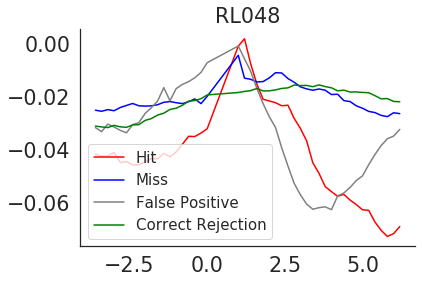

In [50]:
plt.plot(x_axis, hit, color='red', label='Hit')
plt.plot(x_axis, miss, color='blue', label='Miss')
plt.plot(x_axis, fp, color='grey', label='False Positive')
plt.plot(x_axis, cr, color='green', label='Correct Rejection')
plt.legend(loc='bottom', fontsize=15)
plt.title('RL048')

In [51]:
# This no longer works as i am now returning the mean from mean_across_sessions

plt.figure(figsize=(20,20))
normaliser = lambda a: (a - np.min(a))/np.ptp(a)
b = np.apply_along_axis(normaliser, 1, session_means)
plt.imshow(b)
plt.colorbar()

AxisError: axis 1 is out of bounds for array of dimension 1

<Figure size 1440x1440 with 0 Axes>